In [125]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

[autoreload of ClusterPipeline failed: Traceback (most recent call last):
  File "/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 342, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/IPython/e

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [127]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [128]:
raw_data = pd.read_csv("data/original_heart.csv").astype(np.float64)

numerical_cols = ["age","trestbps","chol","thalach","slope","ca","oldpeak"]

original_data = raw_data.drop(columns=["oldpeak", "target"]).astype(np.int64)
original_data["oldpeak"] = raw_data["oldpeak"] # To keep it as a float
original_labels = raw_data["target"].astype(np.int64)

training_labels = raw_data["target"].astype(np.int64)
training_labels[training_labels > 0] = 1

print("Original Distribution:\n",original_labels.value_counts(), sep="")
print("Combined:\n",training_labels.value_counts(), sep="")

original_data.head()

Original Distribution:
0    160
1     54
3     35
2     35
4     13
Name: target, dtype: int64
Combined:
0    160
1    137
Name: target, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,oldpeak
0,63,1,1,145,233,1,2,150,0,3,0,6,2.3
1,67,1,4,160,286,0,2,108,1,2,3,3,1.5
2,67,1,4,120,229,0,2,129,1,2,2,7,2.6
3,37,1,3,130,250,0,0,187,0,3,0,3,3.5
4,41,0,2,130,204,0,2,172,0,1,0,3,1.4


In [129]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

class DataFrameScaler(BaseEstimator, TransformerMixin):
    """
    Returns a numpy matrix of ZScaled columns identified by attribute_names 
    """
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        self.scaler = StandardScaler().fit(X[self.attribute_names])
        return self
    def transform(self, X):
        cat_cols = X.drop(columns=self.attribute_names).values
        scaled_cols = self.scaler.transform(X[self.attribute_names])
        return np.concatenate((scaled_cols, cat_cols), axis=1)

In [130]:
ZScaler = DataFrameScaler(numerical_cols).fit(original_data)
ZScaler.transform(original_data)

array([[ 0.93618065,  0.75038004, -0.27644339, ...,  2.        ,
         0.        ,  6.        ],
       [ 1.3789285 ,  1.59626645,  0.74455507, ...,  2.        ,
         1.        ,  3.        ],
       [ 1.3789285 , -0.65943064, -0.35349988, ...,  2.        ,
         1.        ,  7.        ],
       ...,
       [ 1.48961547,  0.69398761, -1.04700826, ...,  0.        ,
         0.        ,  7.        ],
       [ 0.27205887, -0.09550637, -2.24138382, ...,  0.        ,
         1.        ,  7.        ],
       [ 0.27205887, -0.09550637, -0.21865103, ...,  2.        ,
         0.        ,  3.        ]])

In [131]:
# original_data.drop(columns=original_data.columns).values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4f4ede48>,
      dtype=object)

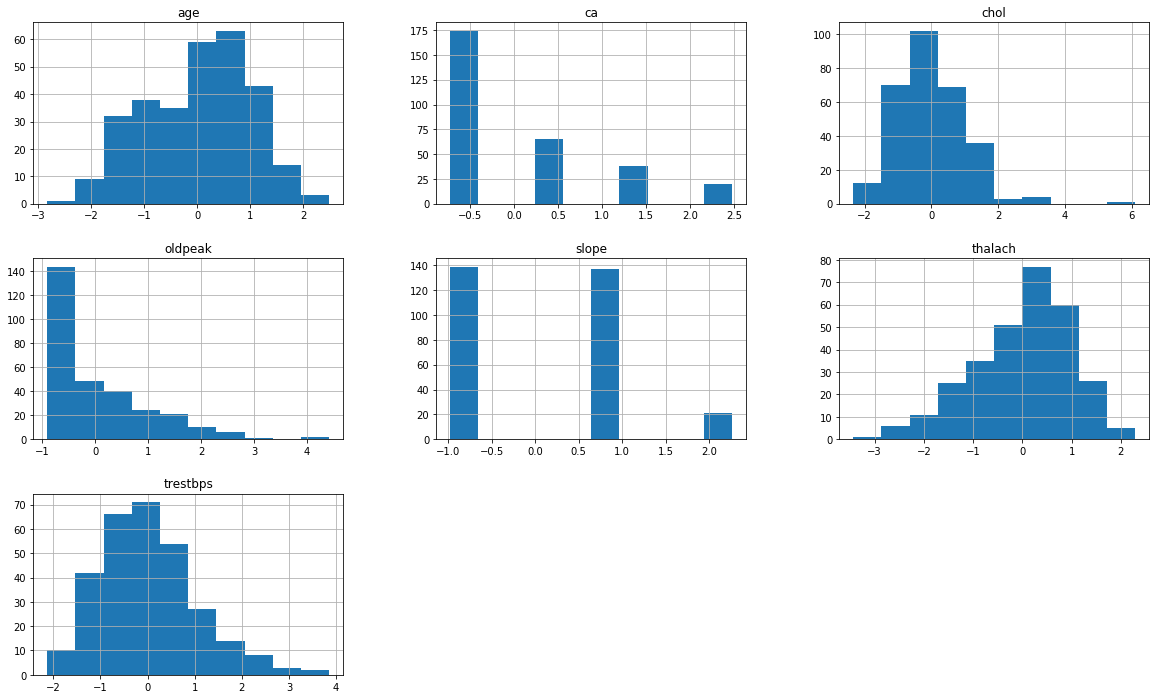

In [132]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(original_data[numerical_cols])

scaled_data = pd.DataFrame(scaled_data, columns=numerical_cols)
scaled_data.hist(figsize=(20,12))

In [133]:
cleveland_data = pd.read_csv("data/heart.csv")
cleveland_data["target"].value_counts()
    
# original_data = raw_data.drop(columns=["target"])
# training_labels = raw_data["target"]
# raw_data.head()
# cleveland_data.dtypes

1    165
0    138
Name: target, dtype: int64

In [134]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal(seed=42)
    

    dnn.add(Dense(units = 25, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 15, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=25, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [135]:
## Need to define a scaling function that ignores categorical values...?

In [136]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                350       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________


In [137]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

In [138]:
# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)    

pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer, numerical_cols = numerical_cols)

pipeline.train_model(batch_size=20,epochs=50, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.607, Acc:0.8333
Prediction Accuracy
28/28 [==============================] - 0s 2ms/step
Scores on data set: loss=0.575 accuracy=0.8214
Fold Correct: 23
Running worker: 1
Fold: 1 -> Loss:0.632, Acc:0.8372
Prediction Accuracy
28/28 [==============================] - 0s 19us/step
Scores on data set: loss=0.618 accuracy=0.8571
Fold Correct: 24
Running worker: 2
Fold: 2 -> Loss:0.592, Acc:0.8527
Prediction Accuracy
28/28 [==============================] - 0s 15us/step
Scores on data set: loss=0.628 accuracy=0.7857
Fold Correct: 22
Running worker: 3
Fold: 3 -> Loss:0.611, Acc:0.8372
Prediction Accuracy
27/27 [==============================] - 0s 17us/step
Scores on data set: loss=0.652 accuracy=0.7037
Fold Correct: 19
Running worker: 4
Fold: 4 -> Loss:0.585, Acc:0.8346
Prediction Accuracy
26/26 [==============================] - 0s 21us/step
Scores on data set: loss=1.022 accuracy=0.6538
Fold Correct: 17
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.79166667 0.20833333]
 [0.20325203 0.79674797]]
Overall Accuracy: 0.7940


(<matplotlib.axes._subplots.AxesSubplot at 0x1a49f79748>, array([[114,  30],
        [ 25,  98]]))

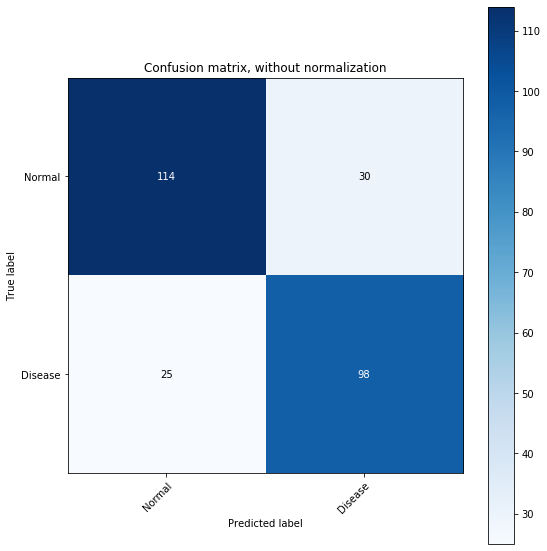

In [139]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

[[0.84722222 0.15277778]
 [0.18699187 0.81300813]]
Overall Accuracy: 0.8315

In [140]:
# min_cluster_sizes=range(10,17,1)
pipeline.train_clusterer(plot=False)

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object


(          Clusters  Noise   Halkidi  Halkidi-Filtered Noise
 (12, 12)         2    0.0  0.451787                0.451787
 (13, 12)         2    0.0  0.451787                0.451787
 (13, 13)         2    0.0  0.451787                0.451787
 (14, 12)         2    0.0  0.451787                0.451787
 (14, 13)         2    0.0  0.451787                0.451787
 (14, 14)         2    0.0  0.451787                0.451787
 (15, 12)         2    0.0  0.451787                0.451787
 (15, 13)         2    0.0  0.451787                0.451787
 (15, 14)         2    0.0  0.451787                0.451787
 (15, 15)         2    0.0  0.451787                0.451787
 (16, 12)         2    0.0  0.451787                0.451787
 (16, 13)         2    0.0  0.451787                0.451787
 (16, 14)         2    0.0  0.451787                0.451787
 (16, 15)         2    0.0  0.451787                0.451787
 (16, 16)         2    0.0  0.451787                0.451787
 (17, 12)         2    0

In [141]:
pd.Series(pipeline.clusterer.labels_).value_counts()

0    57
1    41
dtype: int64

In [142]:
samples, cluster_labels = pipeline.get_validation_clusters()

Prediction Accuracy: 0.9333


In [143]:
pipeline.val_set.labels.value_counts()

0    16
1    14
Name: target, dtype: int64

In [144]:
pd.Series(cluster_labels).value_counts()

0    13
dtype: int64

## Plotting Testing LRP

In [145]:
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp

In [146]:
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)


# reducer = umap.UMAP(random_state=42,
#                     n_components = 2,
#                     n_neighbors=10,
#                     min_dist=0)

# embedding = reducer.fit_transform(training_lrp)

# emb2d = go.Scatter(
#     x=embedding[:,0],
#     y=embedding[:,1],
#     mode="markers"
# )

# layout = go.Layout(
#     title= "2D LRP Embedding"
# )

# data=[emb2d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig)



embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=4,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5'
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-heart.html')

# Comparing Subclusters to Original Data

In [147]:
y_train.head()

101    0
214    0
206    1
241    0
27     0
Name: target, dtype: int64

In [148]:
original_y = original_labels[y_train.index]
original_y.head()

101    0
214    0
206    1
241    0
27     0
Name: target, dtype: int64

In [149]:
y_train.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr].head()

122    1
24     1
137    1
260    0
79     1
Name: target, dtype: int64

In [150]:
# Get testing samples from cross validation
# That were correctly predicted
correct_pred_labels = pipeline.train_set.labels.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr]
split_class = correct_pred_labels == pipeline.target_class

correct_original_target = original_y.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr][split_class]
correct_original_target.head()

122    3
24     4
137    1
79     3
120    4
Name: target, dtype: int64

In [151]:
emb3d["text"] = correct_original_target
emb3d["marker"]["color"] = correct_original_target
emb3d["marker"]["showscale"] = True
emb3d["marker"]["size"] = 5
emb3d["marker"]["colorscale"] = "Viridis"

fig = go.Figure(data=[emb3d], layout=layout)
iplot(fig, filename='lrp-vs-original.html')

# SVM Analysis

In [123]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
]

def runSVM(X,y, X_valid,y_valid):
    np.random.seed(42)
    clf_grid = Pipeline([
        ("scaler", DataFrameScaler(numerical_cols)),
        ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
    ])
    
    clf_grid.fit(X, y)
    grid = clf_grid.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", DataFrameScaler(numerical_cols)),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    svm_clf.fit(X, y)
    print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

    _score = cross_val_score(svm_clf, X=X, y=y, cv=10)
    print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    return svm_clf, _score.mean()

## SVM trained on original data

In [124]:
original_svm, score = runSVM(X_train, y_train, X_valid, y_valid)

{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.800
SVM CV Accuracy: 0.838(+/- 0.140)


**When scaling all values**

{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}

SVM Test Accuracy: 0.800

SVM CV Accuracy: 0.834(+/- 0.136)

## Calculating Entropy

In [114]:
relevance_embedding = embedding
relevance_embedding.shape

(100, 3)

In [115]:
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
    
nsamples = len(relevance_embedding)

nbins  = 200
# xedges = np.linspace(0,1,nbins+1)
# yedges = np.linspace(0,1,nbins+1)
# zedges = np.linspace(0,1,nbins+1)

# axes_ = [x.ravel() for x in np.meshgrid(xedges,yedges,zedges)]

# grid = np.array([x for x in zip(*axes_)])

grid, edges = np.histogramdd(relevance_embedding, bins=nbins)
densities = (grid/nsamples).flatten()

In [116]:
entropy(densities)

4.5774442987656885

In [42]:
# kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(relevance_embedding)
# train_densities = kde.score_samples(relevance_embedding)
# densities = np.exp(kde.score_samples(grid))

# # pd.DataFrame(densities).plot(kind="bar")

# # pd.DataFrame(densities[densities > 0]).plot()
# emb3d["marker"]["color"] = train_densities
# emb3d["marker"]["showscale"]=True
# emb3d["marker"]["colorscale"]="Reds"

# data=[emb3d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='lrp-densities.html')

# entropy(densities)

# %%time

# lowest_bic = np.infty
# bic = []
# n_components_range = range(1, 7)
# cv_types = ['spherical', 'tied', 'diag', 'full']
# for cv_type in cv_types:
#     for n_components in n_components_range:
#         # Fit a Gaussian mixture with EM
#         gmm = GaussianMixture(n_components=n_components,
#                               covariance_type=cv_type)
#         gmm.fit(relevance_embedding)
#         bic.append(gmm.bic(relevance_embedding))
#         if bic[-1] < lowest_bic:
#             lowest_bic = bic[-1]
#             best_gmm = gmm
# best_gmm.fit(relevance_embedding)

# gmm_training_densities = np.exp(best_gmm.score_samples(relevance_embedding))
# gmm_densities = np.exp(best_gmm.score_samples(grid))

# emb3d["marker"]["color"] = gmm_training_densities
# emb3d["marker"]["showscale"]=True
# emb3d["marker"]["colorscale"]="Reds"

# data=[emb3d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='lrp-densities.html')
# print("Entropy:", entropy(gmm_densities))

In [30]:
df = pd.read_csv("data/original_heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [47]:
print("Original Distribution:\n",df["target"].value_counts(), sep="")
original_labels = df["target"]
training_labels = df["target"].copy()
training_labels[training_labels > 0] = 1
print("Combined:\n",training_labels.value_counts(), sep="")

Original Distribution:
0    164
1     55
2     36
3     35
4     13
Name: target, dtype: int64
Combined:
0    164
1    139
Name: target, dtype: int64


In [46]:
training_labels.value_counts()

0    164
1    139
Name: target, dtype: int64